In [ ]:
# from google.colab import runtime
# runtime.unassign()

In [ ]:
# ! pip list

In [ ]:
# ! pip install imageio opencv-python

In [2]:
import os
import cv2
import tensorflow as tf
import numpy as np
from typing import List
from matplotlib import pyplot as plt

2025-05-27 21:20:25.079812: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-05-27 21:20:25.794654: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-05-27 21:20:26.449266: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1748348427.218556    1414 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1748348427.662285    1414 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1748348429.098938    1414 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linkin

# Load Data

In [25]:
# Google
# from google.colab import drive
# drive.mount('/content/drive')
# path = "./drive/MyDrive/Project/Lip_reading/raw_data/"
# test_path = "./drive/MyDrive/Project/Lip_reading/raw_data/videos/s1/bbal6n.mpg"
# al_path = "./drive/MyDrive/Project/Lip_reading/raw_data/alignments/s1/bbal6n.align"

# Local
path = "../raw_data/"
test_path = "../raw_data/videos/s1/bbal6n.mpg"
al_path = "../raw_data/alignments/s1/bbal6n.align"


## Video Loading Test

In [11]:
# Get the video
cap = cv2.VideoCapture(test_path)


In [12]:
# Get 1 frame with each iteration
ret, frame = cap.read()
# Display the frame
frame


array([[[ 88,  65,  56],
        [ 89,  66,  57],
        [106,  64,  58],
        ...,
        [ 55,  30,  21],
        [ 54,  29,  22],
        [ 54,  29,  22]],

       [[212, 189, 180],
        [212, 189, 180],
        [231, 189, 183],
        ...,
        [118,  93,  84],
        [117,  92,  85],
        [117,  92,  85]],

       [[240, 216, 109],
        [241, 217, 110],
        [255, 217, 110],
        ...,
        [129, 111,  40],
        [127, 109,  39],
        [127, 109,  39]],

       ...,

       [[151, 122,  19],
        [151, 122,  19],
        [160, 120,  22],
        ...,
        [102,  83,   4],
        [101,  81,   5],
        [101,  81,   5]],

       [[150, 122,  17],
        [151, 123,  18],
        [160, 121,  20],
        ...,
        [101,  82,   3],
        [101,  81,   5],
        [100,  80,   4]],

       [[150, 122,  17],
        [151, 123,  18],
        [159, 120,  19],
        ...,
        [101,  82,   3],
        [100,  80,   4],
        [100,  80,   4]]

In [14]:
gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

In [15]:
gray[190:236,80:220]

array([[146, 146, 147, ..., 121, 120, 117],
       [146, 146, 147, ..., 121, 117, 116],
       [146, 146, 145, ..., 118, 118, 118],
       ...,
       [137, 137, 137, ..., 112, 111, 111],
       [137, 137, 137, ..., 111, 110, 110],
       [137, 137, 137, ..., 111, 110, 110]], dtype=uint8)

In [16]:
gray = tf.image.rgb_to_grayscale(frame)

2025-05-27 21:23:37.327883: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


In [17]:
# Release the video
cap.release()

## Video Loading Function

In [18]:
def load_video(path: str) -> tf.Tensor:
    '''
    Load a video from a path, convert it to grayscale, crop it to the face,
    normalize it with z-score normalization, and return a numpy array of the frames.
    '''
    cap = cv2.VideoCapture(path)
    frames = []
    for _ in range(int(cap.get(cv2.CAP_PROP_FRAME_COUNT))):
      # Get one frame as a numpy array
      ret, frame = cap.read()
      # Grayscale conversion
      #gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY) # => Returns 2D image
      gray = tf.image.rgb_to_grayscale(frame) # => Returns 3D tensor
      # Add the frame to the list
      frames.append(gray[190:236, 80:220, :])
    # Release the video
    cap.release()

    # Normalize the data with z-score normalization
    mean = tf.math.reduce_mean(frames)
    std = tf.math.reduce_std(tf.cast(frames, tf.float32))

    return tf.cast((frames - mean), tf.float32) / std


In [19]:
frames_test = load_video(test_path)

In [20]:
type(frames_test)

tensorflow.python.framework.ops.EagerTensor

## Char Encoding

In [21]:
# Vocabulary to encode
vocab = [x for x in "abcdefghijklmnopqrstuvwxyz'?!123456789 "]

In [22]:
# Char to num converter
char_to_num = tf.keras.layers.StringLookup(vocabulary=vocab, oov_token="")
# Num to char converter
num_to_char = tf.keras.layers.StringLookup(vocabulary=char_to_num.get_vocabulary(), oov_token="", invert=True)

### Conversion Test

In [23]:
# Conversion test
char_to_num(['g', 'a', 'b', 'e'])

<tf.Tensor: shape=(4,), dtype=int64, numpy=array([7, 1, 2, 5])>

In [24]:
# Retrieving chars test
num_to_char([7, 1, 2, 5])

<tf.Tensor: shape=(4,), dtype=string, numpy=array([b'g', b'a', b'b', b'e'], dtype=object)>

## Alignments Loading Test

In [26]:
# Open align file
with open(al_path, "r") as f:
    lines = f.readlines()

In [27]:
lines

['0 16000 sil\n',
 '16000 21250 bin\n',
 '21250 26750 blue\n',
 '26750 27750 at\n',
 '27750 31500 l\n',
 '31500 39250 six\n',
 '39250 45250 now\n',
 '45250 74500 sil\n']

In [28]:
# Tokienize alignments
tokens = []
for line in lines:
    line = line.split()
    # Ignore silence tokens
    if line[2] != "sil":
        tokens = [*tokens, ' ', line[2]]

tokens

[' ', 'bin', ' ', 'blue', ' ', 'at', ' ', 'l', ' ', 'six', ' ', 'now']

## Alignments Loading Function

In [29]:
def load_alignments(path: str) -> tf.Tensor:
  '''
  Load alignments from a path, tokenize them,
  and return the encoded characters as a 1D tensor.
  '''
  # Open align file
  with open(path, "r") as f:
    lines = f.readlines()

  # Tokenize alignments
  tokens = []
  for line in lines:
      line = line.split()
      # Ignore silence tokens
      if line[2] != "sil":
          tokens = [*tokens, ' ', line[2]]

  return char_to_num(tf.reshape(tf.strings.unicode_split(tokens, input_encoding='UTF-8'), (-1)))[1:]

### Test

In [30]:
x = load_alignments(al_path)

In [31]:
x

<tf.Tensor: shape=(21,), dtype=int64, numpy=
array([ 2,  9, 14, 39,  2, 12, 21,  5, 39,  1, 20, 39, 12, 39, 19,  9, 24,
       39, 14, 15, 23])>

In [32]:
num_to_char(x)

<tf.Tensor: shape=(21,), dtype=string, numpy=
array([b'b', b'i', b'n', b' ', b'b', b'l', b'u', b'e', b' ', b'a', b't',
       b' ', b'l', b' ', b's', b'i', b'x', b' ', b'n', b'o', b'w'],
      dtype=object)>

In [37]:
# path_2 = "./drive/MyDrive/Project/Lip_reading/raw_data/alignments/s1"
path_2 = "../raw_data/alignments/s1"


alignments = []

for file in os.listdir(path_2):
  alignment = load_alignments(os.path.join(path_2, file))
  alignments.append(alignment)
  print(f"Loaded {file}")

Loaded sran8n.align
Loaded bgbu4p.align
Loaded lgiszp.align
Loaded lwws5s.align
Loaded lgwm6n.align
Loaded lgwg3s.align
Loaded braf8n.align
Loaded lgwm9a.align
Loaded swbi6p.align
Loaded bgah3a.align
Loaded bwat4p.align
Loaded sbia1s.align
Loaded pwbx9s.align
Loaded bgaa9a.align
Loaded sgac2n.align
Loaded lbby5a.align
Loaded bgwo2n.align
Loaded prii8p.align
Loaded brwa5a.align
Loaded bram2n.align
Loaded pwax5s.align
Loaded swiu4n.align
Loaded sban2n.align
Loaded bbws8n.align
Loaded brwnzn.align
Loaded srah5s.align
Loaded bwba5s.align
Loaded pbiv1a.align
Loaded lgbm2n.align
Loaded lwir2n.align
Loaded lgal8n.align
Loaded sbwh7s.align
Loaded bwanzp.align
Loaded lray5s.align
Loaded bwaazn.align
Loaded brwn1s.align
Loaded swwp3s.align
Loaded bbal6n.align
Loaded swab8p.align
Loaded pbac3a.align
Loaded pbii1s.align
Loaded lrwf2p.align
Loaded sgbc7s.align
Loaded swbv3s.align
Loaded lwal3s.align
Loaded pgbe3s.align
Loaded pwix2p.align
Loaded bgwb5s.align
Loaded sbig5s.align
Loaded sbat6n.align


In [38]:
max_len = max([tf.shape(tensor)[0].numpy() for tensor in alignments])
print("Longest alignment length:", max_len)

Longest alignment length: 31


## Load Data Function

In [39]:
tf.convert_to_tensor(path).numpy().decode('utf-8')

'./drive/MyDrive/Project/Lip_reading/raw_data/alignments/s1'

In [42]:
def load_data(path: tf.Tensor):
  '''
  Take a path as a tensor, load the video and corresponding alignments,
  and return two tensors, one for the processed frames,
  one for the encoded tokens.
  '''
  # Convert the path back into a string
  path = bytes.decode(path.numpy())

  # Get file name from path
  file_name = path.split('/')[-1].split('.')[0]

  # Get path from file name
  video_path = os.path.join('../raw_data/videos/s1',f'{file_name}.mpg')
  alignment_path = os.path.join('../raw_data/alignments/s1',f'{file_name}.align')

  # Load data
  frames = load_video(video_path)
  alignments = load_alignments(alignment_path)

  return frames, alignments

### Load Test

In [43]:
path_3 = "../raw_data/videos/s1/bbaf2n.mpg"
path_3 = tf.convert_to_tensor(path_3)
f, a = load_data(path_3)

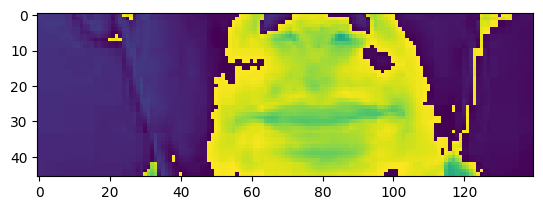

In [44]:
plt.imshow(f[0])

In [45]:
a

<tf.Tensor: shape=(21,), dtype=int64, numpy=
array([ 2,  9, 14, 39,  2, 12, 21,  5, 39,  1, 20, 39,  6, 39, 20, 23, 15,
       39, 14, 15, 23])>

In [46]:
def map_function(path: tf.Tensor):
    result = tf.py_function(load_data, [path], (tf.float32, tf.int64))

# Pipeline

In [59]:
data = 0
data

0

In [60]:
data = tf.data.Dataset.list_files(
    # './drive/MyDrive/Project/Lip_reading/raw_data/videos/s1/*.mpg'
    '../raw_data/videos/s1/*.mpg'
)

In [61]:
data

<_ShuffleDataset element_spec=TensorSpec(shape=(), dtype=tf.string, name=None)>

In [62]:
data = data.shuffle(500, reshuffle_each_iteration=False)

In [63]:
data = data.map(map_function)

InvalidArgumentError: Length for attr 'output_types' of 0 must be at least minimum 1
	; NodeDef: {{node MapDataset}}; Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> [Op:MapDataset] name: 

In [50]:
data = data.padded_batch(2, padded_shapes=([75, None, None, None], [40]))

ValueError: Can't convert Python sequence with mixed types to Tensor.